# Forecasting Air Passenger Traffic

A Comparative Study on the International Airport Passengers Dataset

## Introduction

In this Jupyter Notebook, we delve into the realm of time series forecasting using the "International Airport Passengers" dataset. This dataset is a quintessential example of a time series featuring distinct trends and seasonal variations, making it ideal for benchmarking different forecasting models.

## Objective

Our primary objective is to assess the performance of various time series forecasting models in predicting future trends in passenger traffic. Through this comparison, we aim to discern the capabilities and limitations of each model, particularly in terms of handling complex patterns inherent in time series data.

## Models in Comparison

We will be evaluating four distinct models:

- **ARIMA (AutoRegressive Integrated Moving Average)**: A classic statistical model renowned for capturing linear trends in time series data.
- **LSTM (Long Short-Term Memory)**: A type of recurrent neural network that excels in recognizing long-term dependencies, ideal for non-linear data sequences.
- **LSTM with Attention Mechanism**: Enhancing the standard LSTM's capabilities by incorporating an attention mechanism for better context understanding.
- **CNN (Convolutional Neural Network)**: Typically used in image processing, but also effective in identifying local patterns in sequential data.
- **Transformer**: A recent innovation that employs attention mechanisms to focus on different parts of input data, proving effective in sequence-to-sequence modeling.

## Approach

In our study, we employ two distinct prediction methodologies to evaluate the performance of our models. These methodologies help us understand how well each model can forecast future values under different scenarios.

- **Non-Rolling Prediction**: This approach involves using the trained model to predict future time steps all at once, based solely on the historical data. It is a straightforward prediction method where the model uses the known data to forecast the next steps in the sequence. Non-Rolling Prediction is often used to evaluate the model's performance when complete future data is available for prediction.

- **Rolling Prediction**: Contrary to Non-Rolling Prediction, Rolling Prediction simulates a more realistic scenario where each future time step is predicted one at a time, and each prediction is fed back as input for the next prediction. This method mimics a real-world situation where each prediction depends on the previous ones, and the model does not have access to future data. It is particularly useful for evaluating how well a model adapts to new data and its effectiveness in a continuously updating environment.


### Importing Libraries and Configuration


In [16]:
import pandas as pd
import numpy as np
import random
import os
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, LayerNormalization, Conv1D, MaxPooling1D, Flatten, MultiHeadAttention, Input, GlobalAveragePooling1D, Concatenate, Attention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams

### Settings


In [17]:
rcParams["figure.figsize"] = 15, 6
rcParams["axes.titlesize"] = "xx-large"
rcParams["axes.titleweight"] = "bold"
rcParams["legend.loc"] = "upper left"


# Setting random seeds for reproducibility
seed_value = 42
os.environ["PYTHONHASHSEED"] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

l2_reg=0.001

### Loading and Handling Time Series in Pandas


In [18]:
data = pd.read_csv(
    "https://raw.githubusercontent.com/GVSU-CIS635/Datasets/master/airline-passengers.csv",
    index_col="Month"
)
data.index = pd.to_datetime(data.index, format="%Y-%m")
data.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


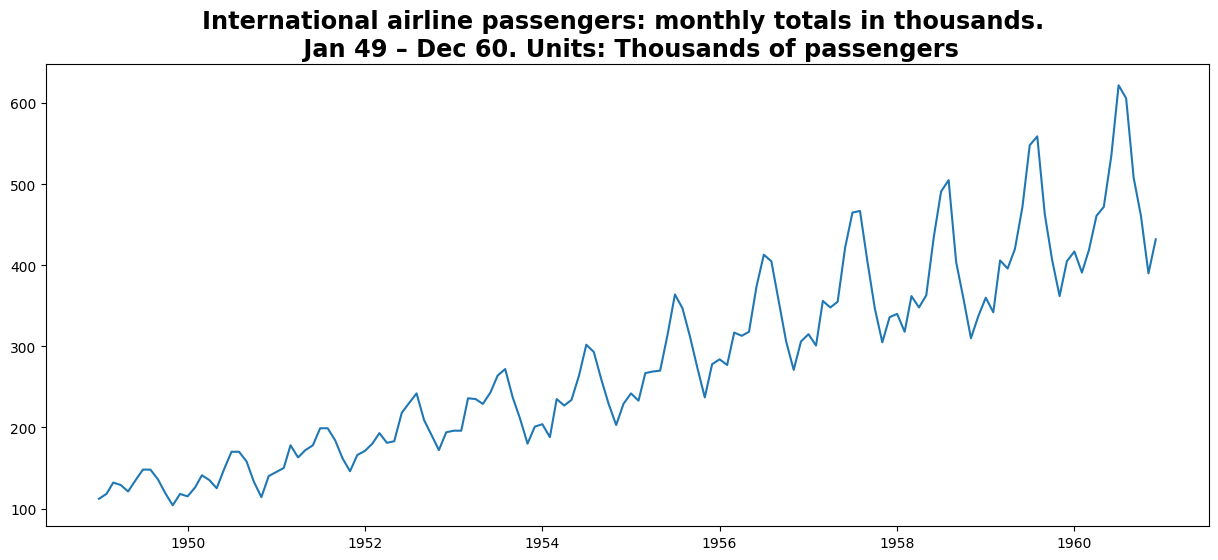

In [19]:
passengers = data["Passengers"]
plt.title(
    "International airline passengers: monthly totals in thousands. \n Jan 49 – Dec 60. Units: Thousands of passengers"
)
plt.plot(passengers)

## ARIMA

### Splitting Data into Training and Test Sets for ARIMA


In [20]:
data_train, data_test = (
    data[:-24],
    data[-24:],
)
print(f"Training {len(data_train)}, Test {len(data_test)}")
print(type(data_train))

Training 120, Test 24
<class 'pandas.core.frame.DataFrame'>


### ARIMA Model Experimentation


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals

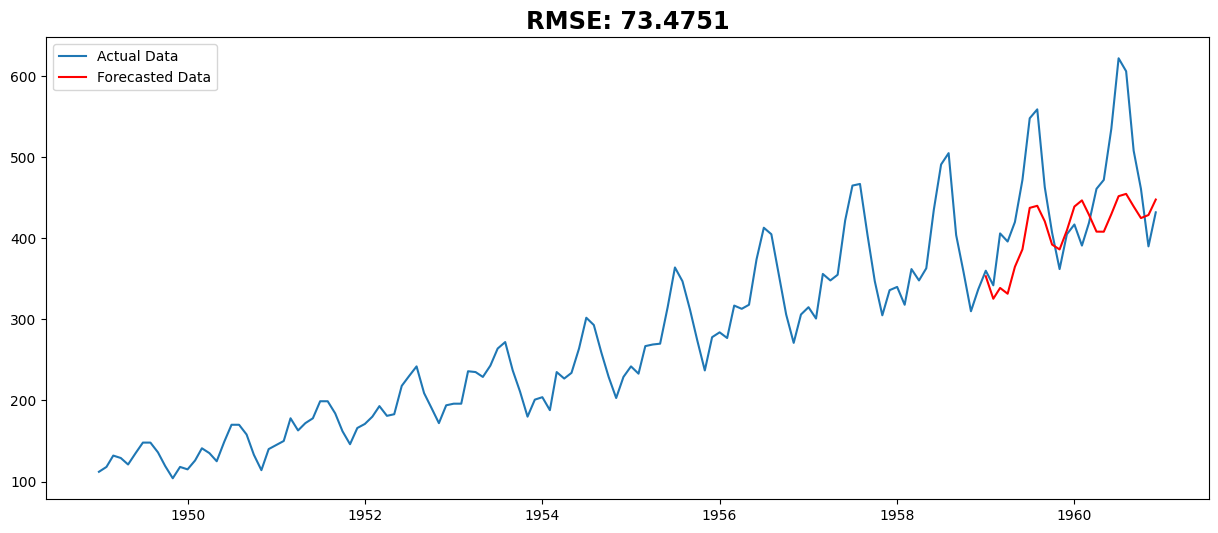

In [23]:
model = ARIMA(data_train, order=(2, 2, 11))
results_ARIMA = model.fit()
yhat = results_ARIMA.forecast(steps=24)
plt.plot(passengers, label="Actual Data")
plt.plot(yhat, color="red", label="Forecasted Data")

# Calculating the RMSE (Root Mean Squared Error)
rmse = mean_squared_error(data_test["Passengers"], yhat, squared=False)
plt.title(f"RMSE: {rmse:.4f}")
plt.legend()
plt.show()

## Neural Networks

### Data Normalization for Neural Network Experiments


(144, 1)


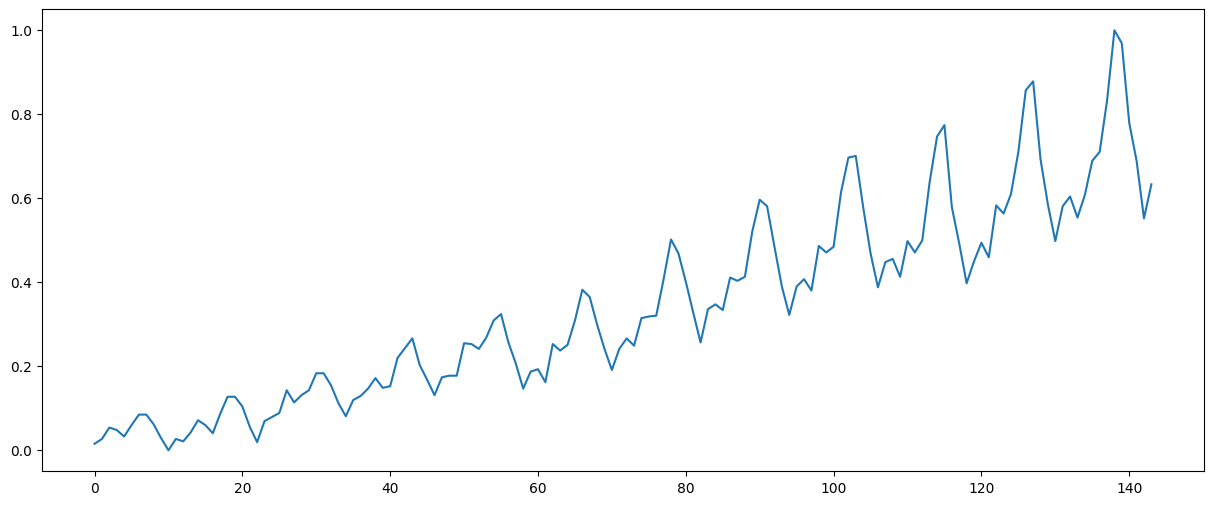

In [24]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
print(scaled_data.shape)
plt.plot(scaled_data)

### Preparing Dataset for Neural Network Models


In [25]:
def create_dataset(sequence, look_back=1):
    X, y = [], []
    for i in range(len(sequence) - look_back):
        end_ix = i + look_back
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [26]:
# Using past 12 time steps to predict the next step
look_back = 12

X, y = create_dataset(scaled_data, look_back)
print("(samples, timesteps, features): " + str(X.shape))

(samples, timesteps, features): (132, 12, 1)


### Splitting Data for Neural Network Models


In [27]:
X_train, y_train = X[:-36], y[:-36]
X_valid, y_valid = X[-36:-24], y[-36:-24]
X_test, y_test = X[-24:], y[-24:]
print(f"training samples shape: {X_train.shape}")
print(f"validation samples shape: {X_valid.shape}")
print(f"test samples shape: {X_test.shape}")

training samples shape: (96, 12, 1)
validation samples shape: (12, 12, 1)
test samples shape: (24, 12, 1)


### LSTM Model Building and Training


In [28]:
lstm = Sequential()
lstm.add(
    LSTM(200, activation="relu", return_sequences=False, input_shape=(look_back, 1), kernel_regularizer=l2(l2_reg)))
lstm.add(LayerNormalization())
lstm.add(Dropout(0.2))
lstm.add(Dense(50, activation='relu', kernel_regularizer=l2(l2_reg)))
lstm.add(Dense(1, kernel_regularizer=l2(l2_reg)))

In [29]:
def network_training(model, model_name):
    learning_rate = 0.001

    # Configure the optimizer with the specified learning rate
    adam_optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss="mean_squared_error", optimizer=adam_optimizer)

    # Early Stopping Callback
    early_stopping = EarlyStopping(
        monitor="val_loss", patience=20, verbose=1, mode="auto"
    )

    # Reduce learning rate when the validation loss plateaus
    reduce_lr = ReduceLROnPlateau(
        monitor="val_loss", factor=0.1, patience=10, verbose=1, min_lr=0.000000001
    )

    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_valid, y_valid),
        epochs=500,
        verbose=1,
        callbacks=[early_stopping, reduce_lr],
    )

    # Plotting the evaluation loss
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title(f"{model_name} Validation Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

Epoch 1/500
3/3 [==============================] - 2s 208ms/step - loss: 0.2277 - val_loss: 0.1734 - lr: 0.0010
Epoch 2/500
3/3 [==============================] - 0s 40ms/step - loss: 0.1660 - val_loss: 0.2898 - lr: 0.0010
Epoch 3/500
3/3 [==============================] - 0s 39ms/step - loss: 0.1245 - val_loss: 0.0973 - lr: 0.0010
Epoch 4/500
3/3 [==============================] - 0s 38ms/step - loss: 0.1007 - val_loss: 0.1130 - lr: 0.0010
Epoch 5/500
3/3 [==============================] - 0s 37ms/step - loss: 0.1062 - val_loss: 0.0937 - lr: 0.0010
Epoch 6/500
3/3 [==============================] - 0s 38ms/step - loss: 0.0932 - val_loss: 0.1339 - lr: 0.0010
Epoch 7/500
3/3 [==============================] - 0s 40ms/step - loss: 0.0948 - val_loss: 0.1122 - lr: 0.0010
Epoch 8/500
3/3 [==============================] - 0s 38ms/step - loss: 0.0877 - val_loss: 0.0931 - lr: 0.0010
Epoch 9/500
3/3 [==============================] - 0s 37ms/step - loss: 0.0893 - val_loss: 0.0910 - lr: 0.0010


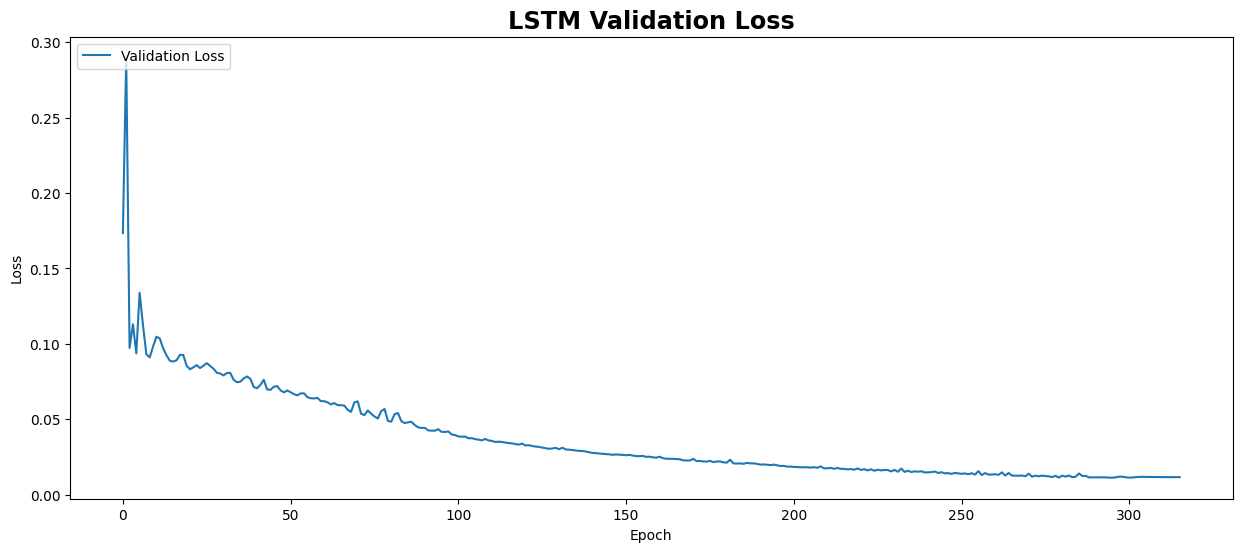

In [30]:
network_training(lstm, "LSTM")

#### Non-Rolling Prediction


In [31]:
def non_rolling_prediction(model, scaler):
    yhat = model.predict(X_test)
    yhat = scaler.inverse_transform(yhat)
    plt.plot(data)
    plt.plot(
        pd.DataFrame(yhat, index=data.index[-24:], columns=["Predictions"]), color="red"
    )

    rmse = mean_squared_error(data[-24:].values, yhat, squared=False)
    plt.title(f"RMSE: {rmse:.4f}")

1/1 [==============================] - 0s 362ms/step


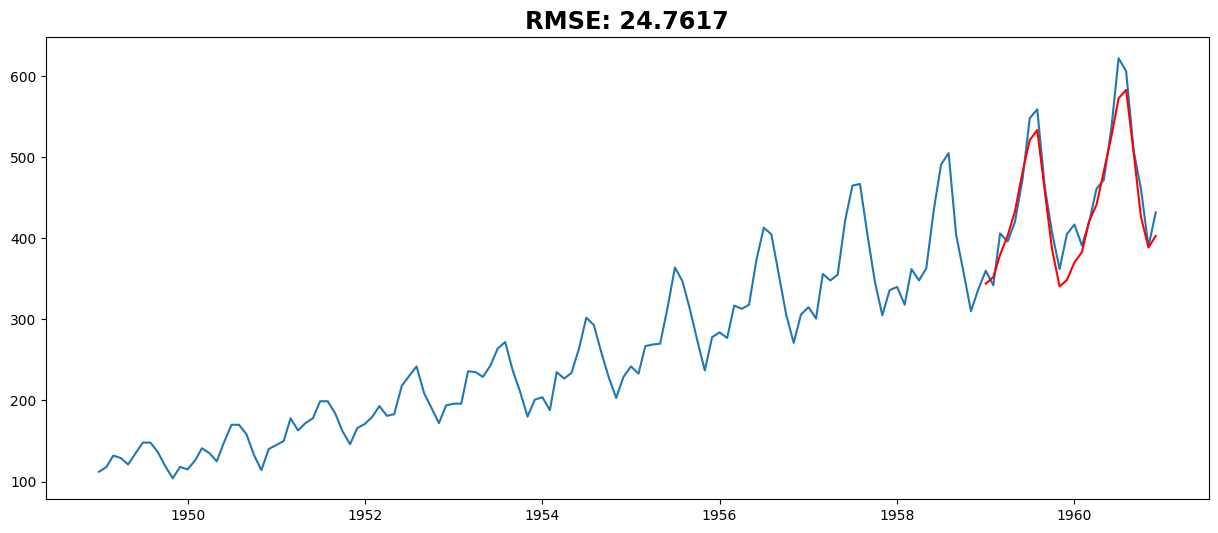

In [32]:
non_rolling_prediction(lstm, scaler)

#### Rolling Prediction


In [33]:
def make_rolling_predictions(model, starting_input, steps, scaler):
    """
    Make rolling predictions using the trained model.

    :param model: The trained model.
    :param starting_input: The initial input data (last known data points).
    :param steps: Number of future time steps to predict.
    :param scaler: The scaler used for data normalization.
    :return: Predictions in original scale.
    """
    input_seq = starting_input.copy()
    predictions = []

    for _ in range(steps):
        # Reshape the input to the format the model expects
        reshaped_input = np.reshape(input_seq, (1, len(input_seq), 1))

        # Make a prediction
        prediction = model.predict(reshaped_input)

        # Append the prediction
        predictions.append(prediction[0, 0])

        # Update the input sequence for the next prediction
        input_seq = np.append(input_seq[1:], prediction)

    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

In [34]:
def rolling_prediction(model, scaler):
    yhat = make_rolling_predictions(
        model, scaled_data[-24 - look_back : -24], 24, scaler
    )
    plt.plot(data)
    plt.plot(
        pd.DataFrame(yhat, index=data.index[-24:], columns=["Predictions"]), color="red"
    )
    plt.legend()
    rmse = mean_squared_error(data[-24:].values, yhat, squared=False)
    plt.title(f"RMSE: {rmse:.4f}")

    plt.show()

1/1 [==============================] - 0s 25ms/step


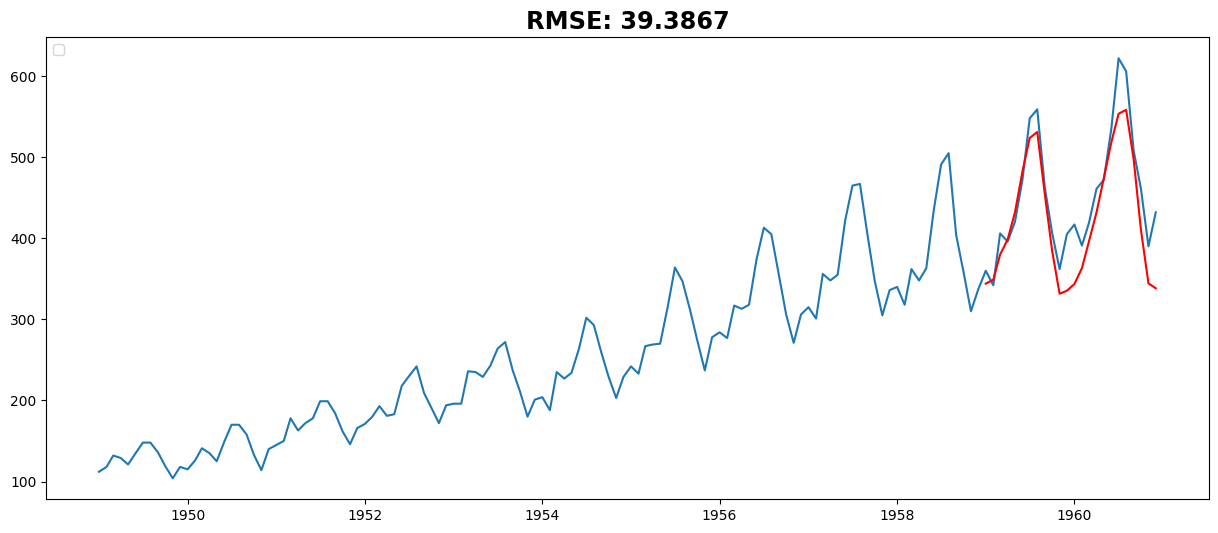

In [35]:
rolling_prediction(lstm, scaler)

### LSTM with Attention Mechanism: Model Building and Training


In [36]:
# Model parameters
input_shape = (look_back, 1)
lstm_units = 200
dropout_rate = 0.2

# Define the model
inputs = Input(shape=input_shape)
lstm_out, state_h, state_c = LSTM(lstm_units, return_sequences=True, return_state=True, kernel_regularizer=l2(l2_reg))(
    inputs
)
attention = Attention()([lstm_out, lstm_out])
context_vector = Concatenate(axis=-1)([attention, lstm_out])
flat = Flatten()(context_vector)
# flat = LayerNormalization()(flat)
dense = Dense(50, activation="relu", kernel_regularizer=l2(l2_reg))(flat)
drop = Dropout(dropout_rate)(dense)
outputs = Dense(1, kernel_regularizer=l2(l2_reg))(drop)

rnn_attention = tf.keras.Model(inputs=inputs, outputs=outputs)

Epoch 1/500
3/3 [==============================] - 3s 490ms/step - loss: 0.1359 - val_loss: 0.2688 - lr: 0.0010
Epoch 2/500
3/3 [==============================] - 0s 73ms/step - loss: 0.1155 - val_loss: 0.0958 - lr: 0.0010
Epoch 3/500
3/3 [==============================] - 0s 64ms/step - loss: 0.0904 - val_loss: 0.1024 - lr: 0.0010
Epoch 4/500
3/3 [==============================] - 0s 77ms/step - loss: 0.0813 - val_loss: 0.0789 - lr: 0.0010
Epoch 5/500
3/3 [==============================] - 0s 75ms/step - loss: 0.0689 - val_loss: 0.0954 - lr: 0.0010
Epoch 6/500
3/3 [==============================] - 0s 73ms/step - loss: 0.0641 - val_loss: 0.0700 - lr: 0.0010
Epoch 7/500
3/3 [==============================] - 0s 78ms/step - loss: 0.0553 - val_loss: 0.0601 - lr: 0.0010
Epoch 8/500
3/3 [==============================] - 0s 72ms/step - loss: 0.0530 - val_loss: 0.0567 - lr: 0.0010
Epoch 9/500
3/3 [==============================] - 0s 60ms/step - loss: 0.0475 - val_loss: 0.0522 - lr: 0.0010


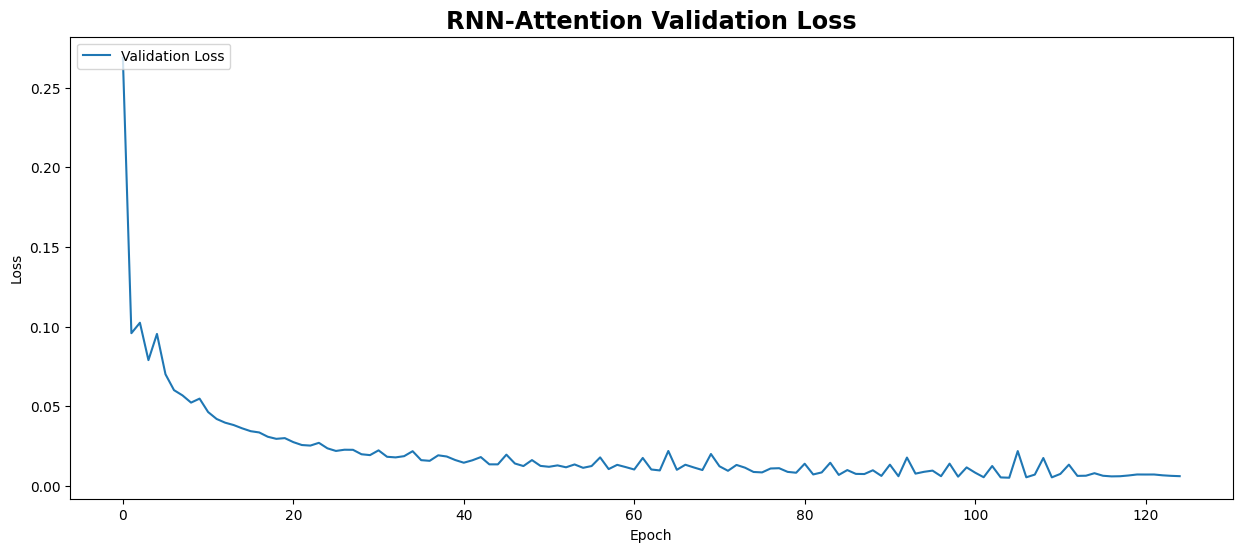

In [37]:
network_training(rnn_attention, "RNN-Attention")

#### Non-Rolling Prediction


1/1 [==============================] - 0s 460ms/step


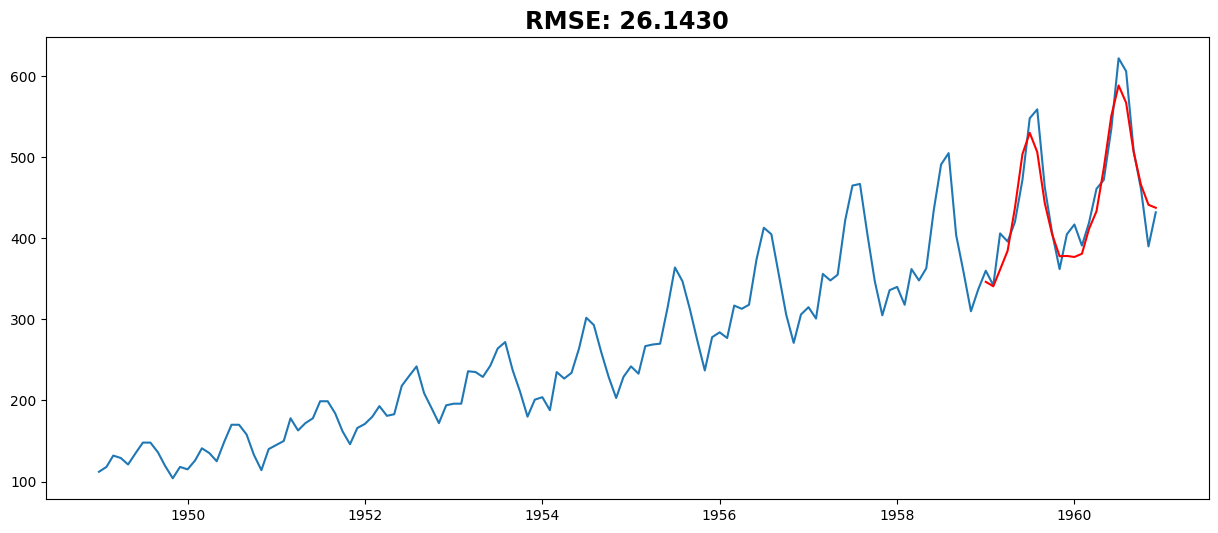

In [38]:
non_rolling_prediction(rnn_attention, scaler)

#### Rolling Prediction


1/1 [==============================] - 0s 27ms/step


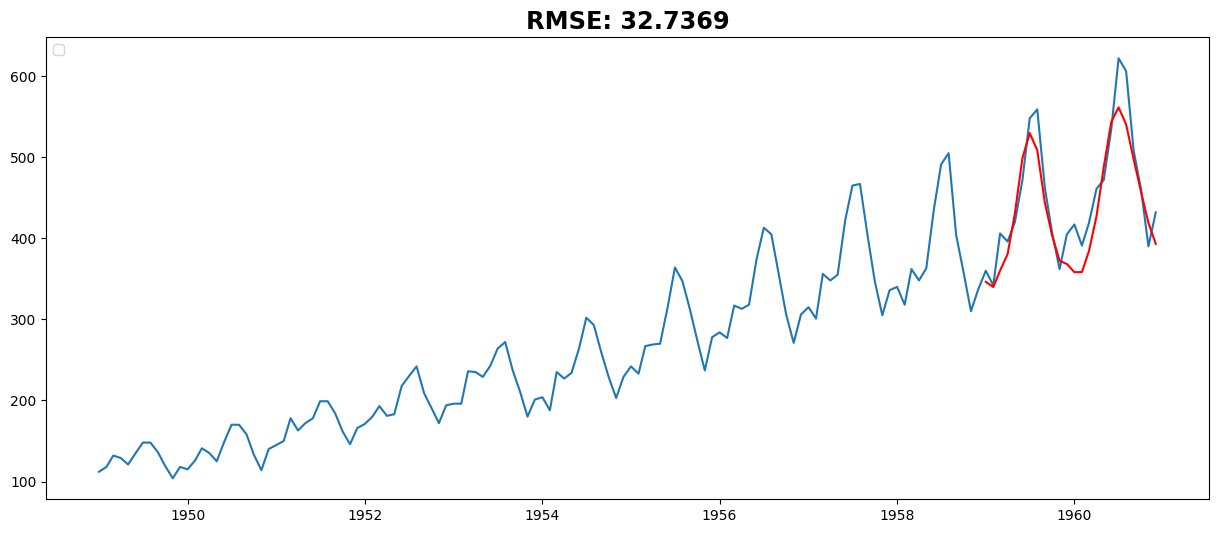

In [39]:
rolling_prediction(rnn_attention, scaler)

### CNN Model Building and Training


In [40]:
cnn = Sequential()

# Input layer - Convolutional layer
cnn.add(
    Conv1D(filters=64, kernel_size=5, activation="relu", input_shape=(look_back, 1)))

# Additional convolutional layer
cnn.add(Conv1D(filters=64, kernel_size=5, activation="relu"))

# Max pooling layer
cnn.add(MaxPooling1D(pool_size=2))

# Flatten layer to prepare data for Dense layer
cnn.add(Flatten())

# Dense layer for prediction
cnn.add(Dense(50, activation='relu', kernel_regularizer=l2(l2_reg)))
cnn.add(Dense(1, kernel_regularizer=l2(l2_reg)))

Epoch 1/500
3/3 [==============================] - 2s 100ms/step - loss: 0.1824 - val_loss: 0.2944 - lr: 0.0010
Epoch 2/500
3/3 [==============================] - 0s 18ms/step - loss: 0.1279 - val_loss: 0.1975 - lr: 0.0010
Epoch 3/500
3/3 [==============================] - 0s 17ms/step - loss: 0.0987 - val_loss: 0.1225 - lr: 0.0010
Epoch 4/500
3/3 [==============================] - 0s 18ms/step - loss: 0.0772 - val_loss: 0.0856 - lr: 0.0010
Epoch 5/500
3/3 [==============================] - 0s 22ms/step - loss: 0.0726 - val_loss: 0.0943 - lr: 0.0010
Epoch 6/500
3/3 [==============================] - 0s 17ms/step - loss: 0.0754 - val_loss: 0.0921 - lr: 0.0010
Epoch 7/500
3/3 [==============================] - 0s 20ms/step - loss: 0.0705 - val_loss: 0.0796 - lr: 0.0010
Epoch 8/500
3/3 [==============================] - 0s 20ms/step - loss: 0.0648 - val_loss: 0.0769 - lr: 0.0010
Epoch 9/500
3/3 [==============================] - 0s 18ms/step - loss: 0.0619 - val_loss: 0.0793 - lr: 0.0010


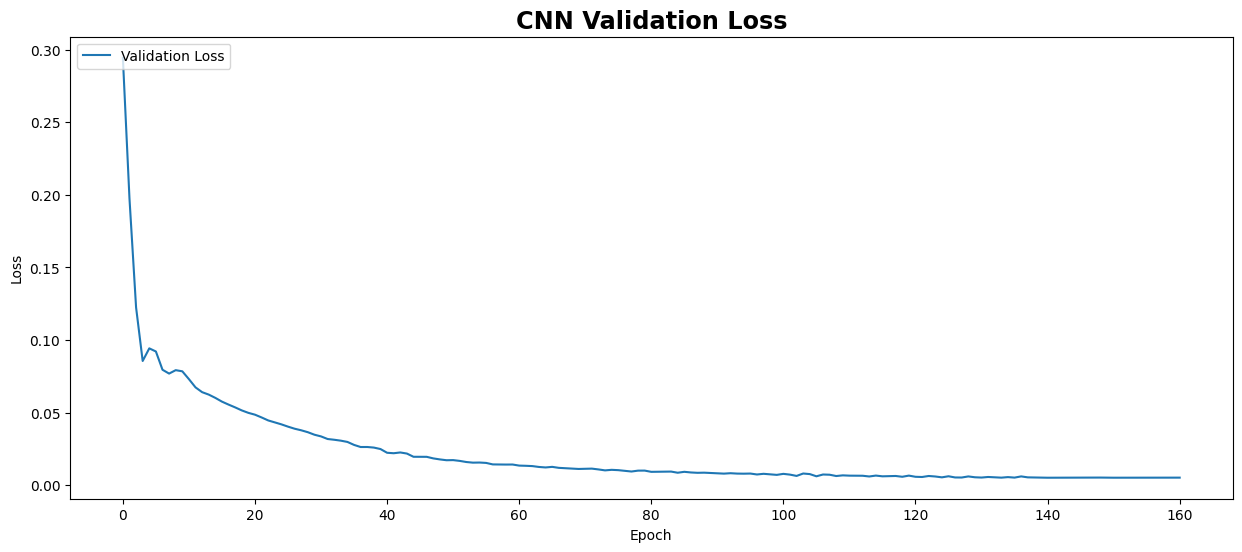

In [41]:
network_training(cnn, "CNN")

#### Non-Rolling Prediction


1/1 [==============================] - 0s 91ms/step


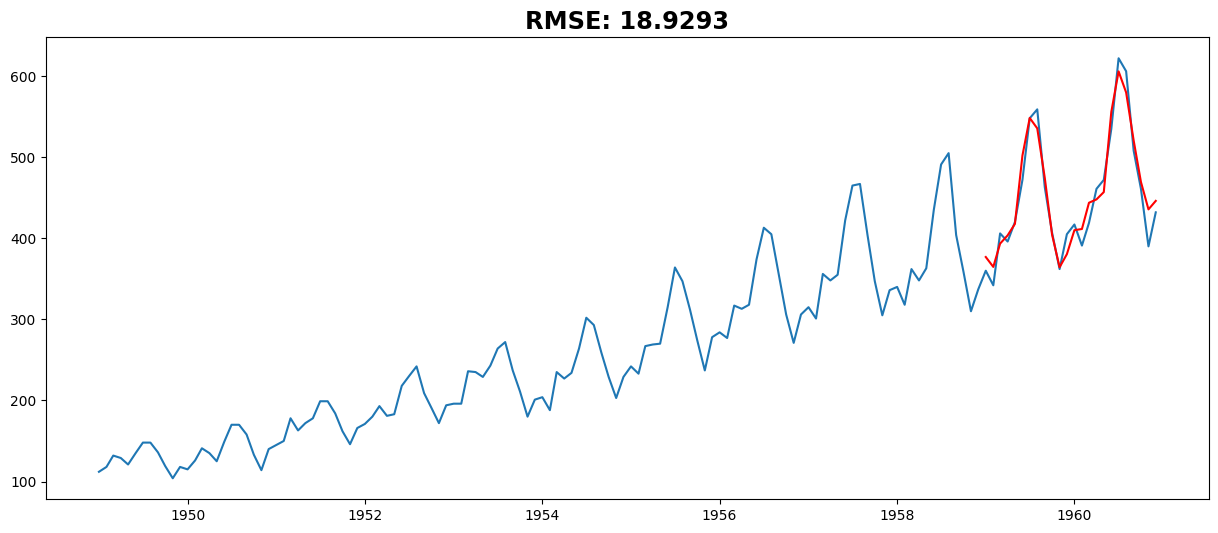

In [42]:
non_rolling_prediction(cnn, scaler)

#### Rolling Prediction


1/1 [==============================] - 0s 20ms/step


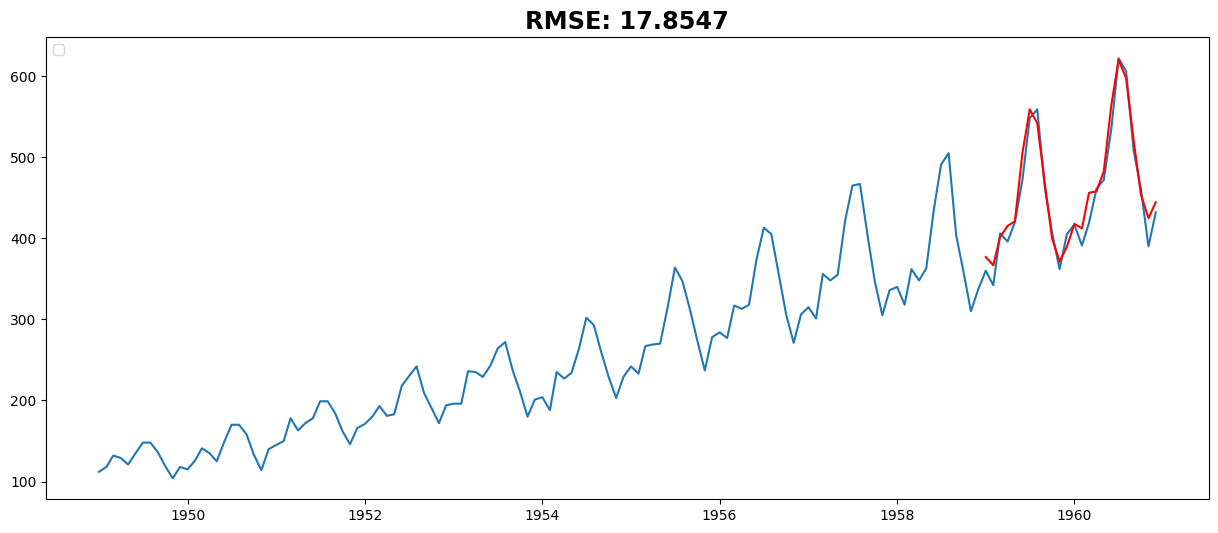

In [43]:
rolling_prediction(cnn, scaler)

### Transformer Model Building and Training


In [49]:
# Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    # x = LayerNormalization()(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(
        inputs, inputs
    )
    x = Dropout(dropout)(x)
    res = x + inputs
    # res = LayerNormalization()(res)

    # Feed Forward Part
    # x = LayerNormalization()(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    res = x + res
    # res = LayerNormalization()(res)
    return res

In [61]:
# Model parameters
ff_dim = 64  # Hidden layer size in feed forward network inside transformer
num_heads = 4  # Number of attention heads
dropout_rate = 0.2  # Dropout rate
head_size = 64  # Attention head size

# Model building
inputs = Input(shape=(look_back, 1))
x = inputs

# Transformer layers
x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout_rate)

# Global Pooling and Output
x = GlobalAveragePooling1D(data_format="channels_first")(x)
x = Dropout(dropout_rate)(x)
x = Dense(50, activation='relu', kernel_regularizer=l2(l2_reg))(x)
x = Dense(1, activation='relu', kernel_regularizer=l2(l2_reg))(x)



# Build the model
transformer = tf.keras.Model(inputs=inputs, outputs=x)

Epoch 1/500
3/3 [==============================] - 6s 719ms/step - loss: 0.0632 - val_loss: 0.1102 - lr: 0.0010
Epoch 2/500
3/3 [==============================] - 0s 31ms/step - loss: 0.0524 - val_loss: 0.0651 - lr: 0.0010
Epoch 3/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0452 - val_loss: 0.0528 - lr: 0.0010
Epoch 4/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0461 - val_loss: 0.0522 - lr: 0.0010
Epoch 5/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0395 - val_loss: 0.0461 - lr: 0.0010
Epoch 6/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0326 - val_loss: 0.0394 - lr: 0.0010
Epoch 7/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0289 - val_loss: 0.0365 - lr: 0.0010
Epoch 8/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0307 - val_loss: 0.0369 - lr: 0.0010
Epoch 9/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0283 - val_loss: 0.0354 - lr: 0.0010


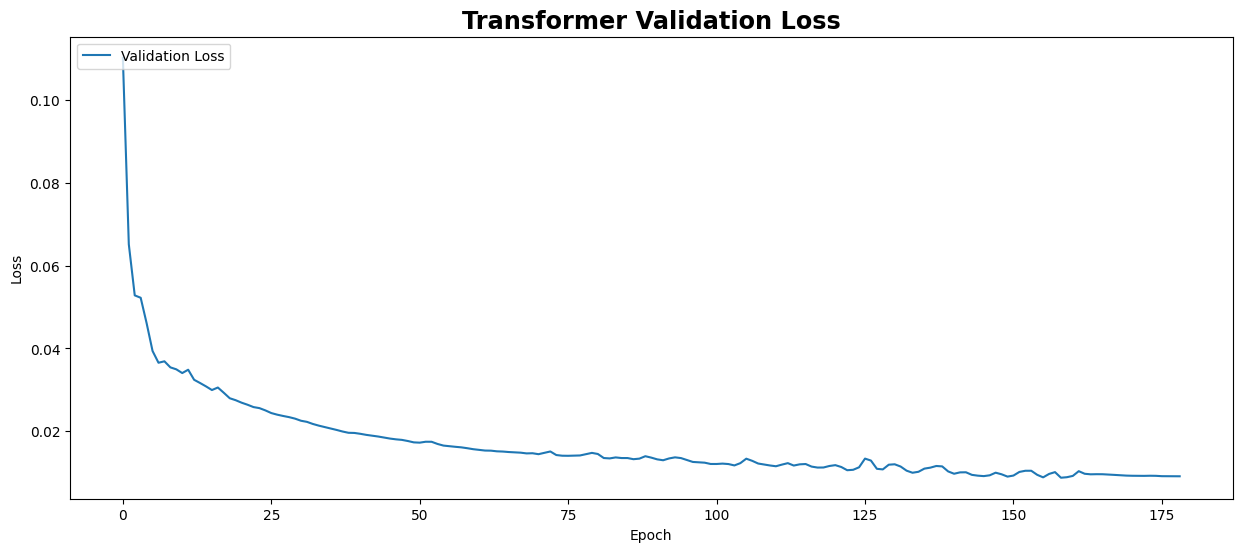

In [62]:
network_training(transformer, "Transformer")

#### Non-Rolling Prediction


1/1 [==============================] - 0s 176ms/step


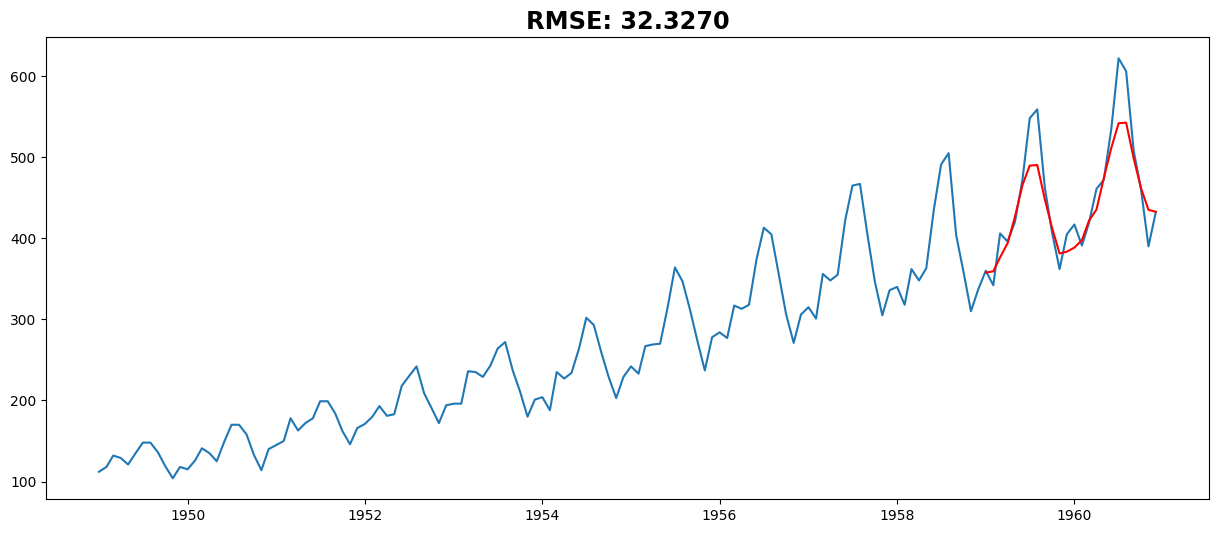

In [63]:
  non_rolling_prediction(transformer, scaler)

#### Rolling Prediction


1/1 [==============================] - 0s 25ms/step


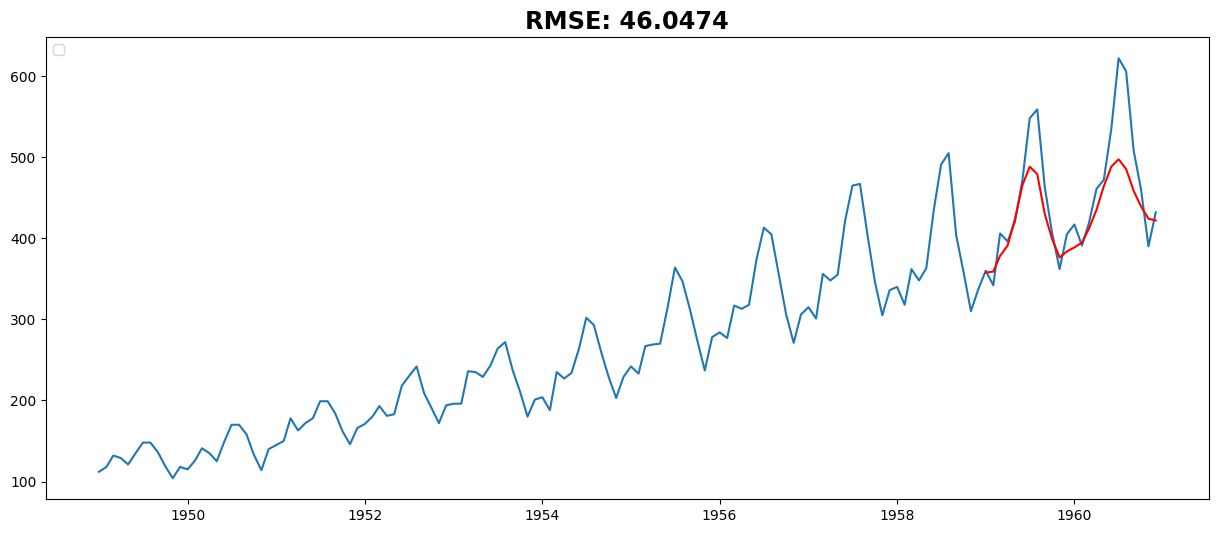

In [64]:
rolling_prediction(transformer, scaler)